# [수비니움 캐글 따라하기] 주택 가격 예측 : Advanced

본 커널은 다음과 같은 커널을 추가적으로 공부하며, Stacking 테크닉을 이용해봅니다.

- [Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)

Thanks to @serigne for awesome kernel.

이번엔  주택 가격 예측 문제를 stacking 테크닉을 사용하여 좋은 결과를 내는 과정입니다.

Stacking과  앙상블, 스태킹을 하는 부분에 있어서 class로 만들어 사용하는 것과 데이터의 분포를 맞추는 과정 등을 배울 수 있습니다.
또한 교차 검증도 따로 함수로 만들어 사용하는 등 저에게는 배울 점이 많은 커널이 었습니다.

하지만 비교적 사전 지식이 많이 필요한 커널입니다. 내용 자체가 친절한 커널은 아닙니다.
하이퍼 파라미터의 설정이 왜 그렇게 됬는지 설명이 부족하고, 코드에 대한 설명 또한 부족합니다.

그렇기에 머신러닝을 접한지 얼마 안된 분에게는 추천하지 않을 것 같지만, 스태킹과 앙상블 과정을 따라하기에는 좋은 커널이었습니다.

> 이 문제의 앙상블과 스태킹 등의 기법에 있어서는 [파이썬 머신러닝 완벽 가이드] 책에도 상세하게 기술되어있습니다. 

더 많은 정보를 업로드하고 있으니 많은 좋아요와 구독 부탁드립니다.

- **블로그** : [안수빈의 블로그](https://subinium.github.io)
- **페이스북** : [어썸너드 수비니움](https://www.facebook.com/ANsubinium)
- **유튜브** : [수비니움의 코딩일지](https://www.youtube.com/channel/UC8cvg1_oB-IDtWT2bfBC2OQ)

#### 특성 공학

- Inputing missing values
- Transforming : 수치형 -> 범주형
- Label Encoding : 범주형 -> 서수형
- Box Cox Transformation : 비대칭 분포 데이터에 대해 좀 더 좋은 결과(리더보드와 cross-validation에서)를 낼 수 있음
- Getting dummy variables : 범주형 특성

#### 알고리즘

본 커널에서는 stacking/emsemble을 하기 전 다음과 같은 모델을 선택하고, cross-validate합니다..

- sklearn based model
- DMLS's XGBoost
- Microsoft's LightGBM

또한 stacking 및 앙상블 방법으로 가장 간단한 방법(평균)과 비교적 어려운 방법으로 총 2가지 방법으로 예측값을 높입니다.


## 라이브러리, 데이터 확인하기

우선 필요한 라이브러리를 불러오고, 데이터의 형태를 가볍게 확인해봅시다.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm, skew
import warnings
warnings.filterwarnings('ignore') # warnings 무시
%matplotlib inline

# sns Theme 
sns.set_style('darkgrid') 

# 소수점 표현 제한
pd.set_option('display.float_format', lambda x : '{:.3f}'.format(x))

# 디렉토리 내, 사용가능 파일 체크 
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

data_description.txt
sample_submission.csv
test.csv
train.csv



In [2]:
# 데이터 읽기
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

In [3]:
# 데이터체크
print(train_df.shape, test_df.shape)
train_df.head(5)

(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


가격 특성을 제외하면 80개의 특성을 가지고 있습니다. 그 외에는 데이터 분석과 상관 없는 Id  특성도 있습니다.

In [4]:
# Save the 'Id' comlumn
train_ID = train_df['Id']
test_ID = test_df['Id']

# drop the 'Id' column since it's unnecessary for the prediction process
train_df.drop('Id', axis=1, inplace=True)
test_df.drop('Id', axis=1, inplace=True)

## Data Processing

### Outliers

공식 [Documetation](http://jse.amstat.org/v19n3/decock.pdf)에서는 데이터에 이상 치가 있다고 언급하고 있습니다.
그 이상치를 찾아 어떻게 처리할 것인가가 이 문제의 핵심이 될 수 있습니다.

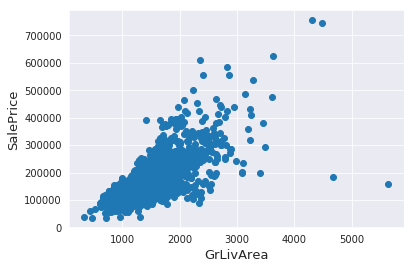

In [5]:
fig, ax = plt.subplots()

ax.scatter(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

이 그래프를 보면 낮은 SalePrice에서 그래프와 다르게 이상한 2개의 데이터를 확인할 수 있습니다.
이 데이터를 더 나은 훈련을 위해 삭제하겠습니다.

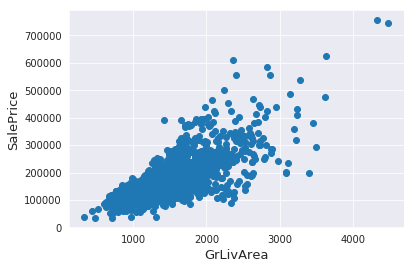

In [6]:
#Deleting outlier
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index) 

#Check the Graph again
fig, ax = plt.subplots()
ax.scatter(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

이상치 제거는 훈련에 있어 매우 좋은 방법입니다.

이상치를 일일히 찾아 제거하지 않는 이유는 다음과 같습니다.

- 이 외에도 훈련 데이터에 이상치가 많을 수 있지만, 테스트 데이터에도 이상치가 있을 수 있습니다.
- 그렇다면 오히려 모델에 안좋은 영향을 미칠 수 있습니다.

이런 이상치를 모두 제거하는 대신에 후에 모델에서 이런 데이터를 제어하는 방법을 배울 것입니다.

### Target Variable

**SalePrice**는 우리가 예측해야 하는 타겟 값입니다. 이제 이 데이터부터 먼저 분석해보겠습니다.

다음 그래프를 이해하기 위해는 다음과 같은 선지식이 필요합니다.

- Q- Q Plot : 간단하게 두 데이터 집단 간의 분포를 체크

**reference** 

더 많은 정보는 아래의 링크를 참고하시면 됩니다.

- [Q-Q wiki](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot)
- [Q-Q plot 한글 블로그 자료 : sw4r님](http://blog.naver.com/PostView.nhn?blogId=sw4r&logNo=221026102874&parentCategoryNo=&categoryNo=43&viewDate=&isShowPopularPosts=true&from=search)

180932.91906721535 79467.78892987774


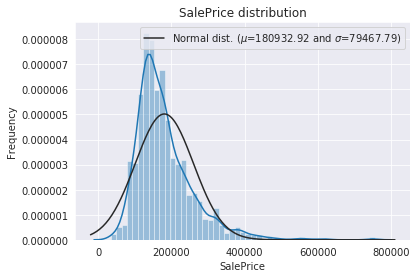

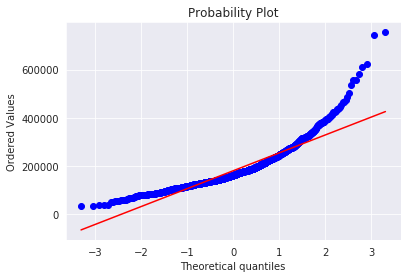

In [7]:
sns.distplot(train_df['SalePrice'], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print(mu, sigma)

# 분포를 그래프에 그려봅시다
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ-plot을 그려봅시다.
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

분포가 오른쪽으로 치우친 것을 알 수 있습니다.
일반적으로 선형 모델은 분포가 균형잡힌 상태에 더 용이하므로 데이터를 좀 더 손보면 좋을 것 같습니다.

#### Log-transformation of the target variable 

데이터의 정규화를 위해 numpy의 `log1p` (모든 column의 원소에  $log(1+x)$) 함수를 사용하여 데이터를 처리해보도록 하겠습니다.

12.024015155682552 0.3995757283645756


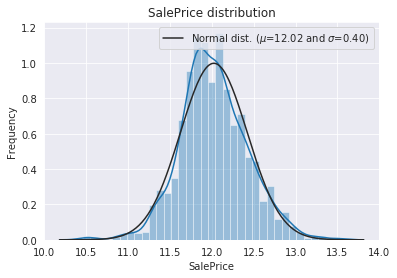

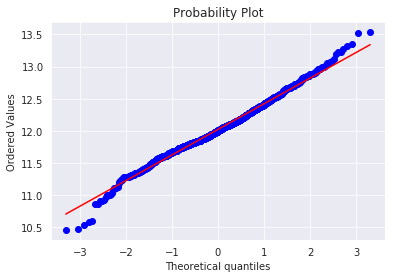

In [8]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

# 위에서와 같은 코드로 똑같이 분포를 확인해봅니다.
sns.distplot(train_df['SalePrice'], fit=norm)
(mu, sigma) = norm.fit(train_df['SalePrice'])
print(mu, sigma)
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

이제 정규분포에 매우 근접하게 값들이 바뀐 것을 알 수 있습니다.

## Feature Engineering

우선 처리하기에 앞서 데이터를 하나로 묶어서 사용하겠습니다.

In [9]:
ntrain = train_df.shape[0]
ntest = test_df.shape[0]

y_train = train_df.SalePrice.values

all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


### Missing Data

이제 전체 데이터에서 빈 부분을 확인해보도록 하겠습니다.

In [10]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

missing_data = pd.DataFrame({"Missing Ratio" : all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


이제 이 데이터를 시각화합니다.

Text(0.5,1,'Percent missing data by feature')

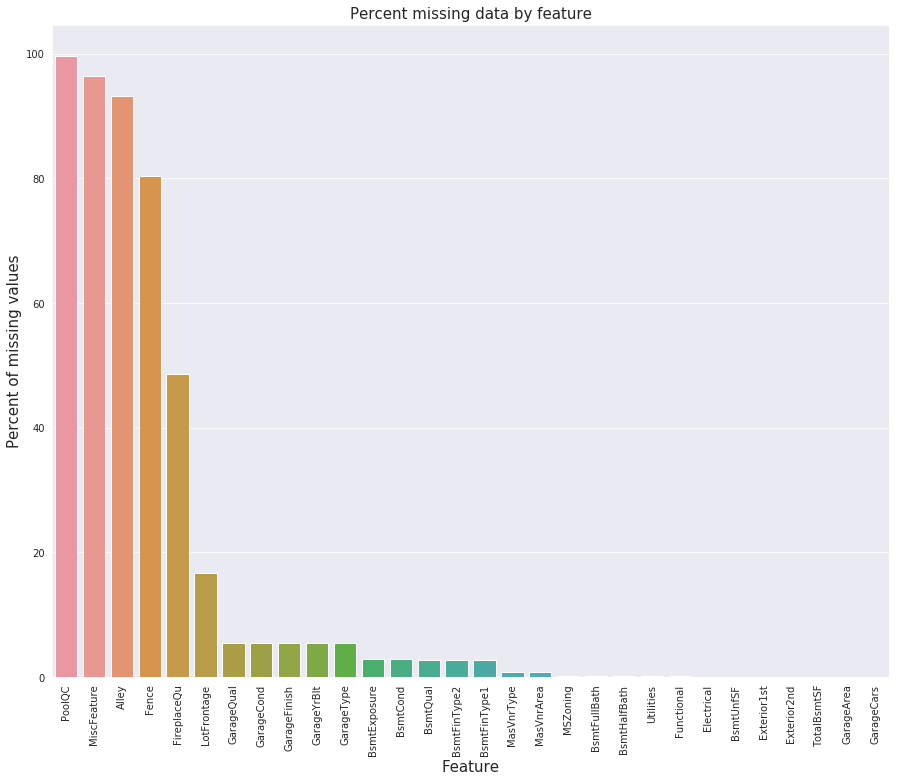

In [11]:
f, ax = plt.subplots(figsize=(15,12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

### Data Correlation

heatmap을 이용하면 각 요소의 상관관계를 시각화하여, 더 직관적으로 볼 수 있습니다.
여기서 초점으로 봐야하는 요소는 지금 구하고자하는 값인 SalePrice와 다른 요소간의 상관관계입니다.

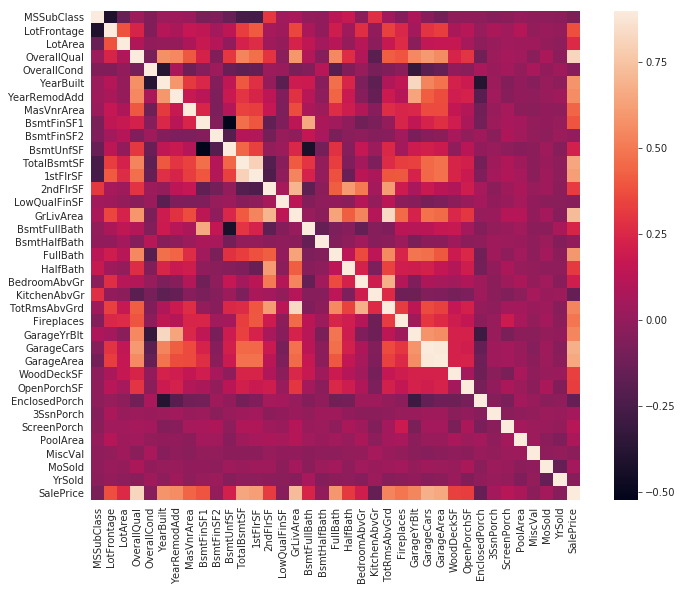

In [12]:
corrmat = train_df.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

### Inputing missing values

이제 누락된 값을 채워넣도록 합시다. 이제부터 누락된 값이 있는 특성들을 하나씩 차례로 볼 차례입니다.

- **PoolQC** : 디스크립션에 따르자면  NA값은 "No Pool"을 의미한다고 합니다. 99%의 값을 채워줍시다.

In [13]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

- **MiscFeature** : 디스크립션에 따르면 NA는 "no misc feature"이라고 합니다.
이 외에도 **Alley, Fence, FireplaceQu**도 비슷하게 ~없다 이므로 함께 처리합니다.

In [14]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

- **LotFrontage** : 거리와 집의 거리 요소로, 이 값들은 이웃들의 거리와 유사한 값을 가질 것입니다. 손실된 값들은 이웃들의 중앙값으로 채워넣겠습니다.

In [15]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x : x.fillna(x.median()))

- **GarageType, GarageFinish, GarageQual and GarageCond** : 이 부분도 None으로 처리하겠습니다.

In [16]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

다시 빈데이터들을 'None' 또는 0으로 처리합니다.

In [17]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [18]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [19]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [20]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

 - **MSZoning (The general zoning classification)** : RL이 최빈값으로 빈 부분은 RL로 채웁니다. mode 메서드는 가장 많이 나타나는 값을 자동으로 선택해줍니다.

In [21]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- **Utilities** : 이 데이터는 모든 값이 "AllPub"으로 되어있고, 한개가 "NoSeWa" 그리고 2개의 NA값이 있습니다. 이는 예측하는 데에 있어 전혀 유용하지 않을 것 같으니 drop합시다.

In [22]:
all_data = all_data.drop(['Utilities'], axis=1)

- **Functional** : 디스크립션에 의하면  NA는 typical을 의미한다고 합니다.

In [23]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

- **Electrical, KitchenQual, Exterior1st and Exterior2nd, SaleType** :  이 데이터 모두 최빈값으로 채워줍시다.

In [24]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [25]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

In [26]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [27]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [28]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

마지막으로 아직까지 채우지 못한 데이터가 있는지 체크해봅시다.

In [29]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


### More features engineering

#### Transforming some numerical variable that are really categorical

수치형 값들 중 범주형인 특성들을 변환합시다.

In [30]:
# MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].apply(str)

# Year and Month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

#### Label Encoding some categorical variables that may contain information in their ordering set

범주형 데이터를 label encoding으로 변환합니다.

In [31]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


#### Adding one more important feature

주택 가격에서 중요한 요소 중 하나는 집의 가용 평수입니다. 그렇기에 이런 특성을 basement + 1층 + 2층 공간으로 새로운 특성을 하나 만들겠습니다.

In [32]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

#### Skewed feature

In [33]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# 수치형 데이터에서 skewness 체크
skewed_feats = all_data[numeric_feats].apply(lambda x : skew(x.dropna())).sort_values(ascending=False)

print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)



Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


#### Box Cox Transformation of (highly) skewed features

Box-Cox Transformation은 정규 분포가 아닌 데이터를 정규 분포 형태로 변환하는 방법 중 하나입니다.

보다 자세한 내용은 다음을 참고하길 바랍니다.

**Reference**

- [Box Cox Transformation](https://en.wikipedia.org/wiki/Power_transform)

In [34]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    

There are 59 skewed numerical features to Box Cox transform


#### Getting dummy categorical features

범주형 데이터를 get_dummies를 이용하여 변환합니다. 그리고 다시 train_df와 test_df로 나누겠습니다.

In [35]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

(2917, 220)


##  Modeling

###  Import Libraries 

이제 모델들의 라이브러리를 import합시다.

In [36]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

### Define a cross validation strategy

이 커널에서는 **cross_val_score** 함수를 사용합니다. 하지만 이 함수는 순서를 섞지 않기 때문에 검증의 정도를 높이기 위해 K-fold를 사용하여 검증의 정확도를 더 높입니다.

In [37]:
# Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_df.values)
    rmse = np.sqrt(-cross_val_score(model, train_df.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return (rmse)

## Base models

- **LASSO Regression**
이 모델은 이상치에 매우 민감합니다. 그렇기에 이런 이상치를 좀 더 규제하기 위해 pipeline에  `RobustScaler()` 메서드를 이용합니다.

- **Elastic Net Regression**
이 모델 또한 이상치를 위해 똑같이 합니다.

In [38]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

- **Kernel Ridge Regression**

In [39]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

- **Gradient Boosting Regression**

**huber** 손실 함수로 이상치를 관리합니다. 이 손실함수는 다른 손실함수에 비해 이상치에 대해 민감하지 않습니다.

Reference

- [huber wiki](https://en.wikipedia.org/wiki/Huber_loss)



In [40]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4,
                                   max_features='sqrt', min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=5)

- **XGBoost** 

각 매개변수, 즉 하이퍼 파라미터 설정은 bayesian optimization을 사용했다고 하였습니다.

저는 아직 그 사용을 잘 모르겠으나 다음을 참고하면 됩니다. [link](https://github.com/fmfn/BayesianOptimization)


In [41]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

- **LightGBM**

In [42]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### Base models scores

이제 이 모델들을 이용해 교차 검증을 통해 score를 구해봅시다.

In [43]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)



In [44]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



In [45]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)



In [46]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1177 (0.0080)



In [47]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Xgboost score: 0.1162 (0.0078)



In [48]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1167 (0.0072)



## Stacking models

### Simplest Stacking approach : Averaging base models

우선 모델들의 성능을 평균하여 사용하는 것으로 시작해봅시다.
**class**를 만들어 캡슐화하고, 코드를 재사용할 수 있게 만들어봅시다.


In [49]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

### Averaged base models score

이제 **ENet, GBoost, KRR and lasso**를 이용해 score를 내봅시다. 다른 모델을 추가해도 됩니다.

In [50]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged base models score: 0.1091 (0.0075)



### Less simple Stacking : Adding a Meta-model

이 방법은 meta model을 추가하고, base model들의 평균과 이 out-of-folds 예측을 이용하여 meta-model을 훈련시킵니다.

기본적인 흐름은 다음과 같습니다.

1. 훈련 데이터를 분리된 데이터셋 train, holdout으로 나눕니다.
2. train 데이터로 훈련을 하고
3. holdout 데이터로 테스트 합니다.
4. 3)을 통해 예측값을 구하고, **meta model**을 통해 그 예측 값으로 모델을 학습합니다.

첫 세 단계는 순서대로 진행하면 됩니다. 만약 5-fold stacking을 한다면, 5-folds를 예시로 들어봅니다.

그렇다면 훈련 데이터를 5개로 나누고, 총 5번의 반복문을 진행하면 됩니다. 각 반복문은 4 folds로 훈련을 진행하고, 나머지 1 fold를 예측합니다.

그렇다면 5번의 반복문이 끝나면 모든 데이터는 out-of-folds 예측값을 가지게 되고, 이제 이 값들을 이용해 meta model의 입력으로 사용합니다. (4)

예측 부분에 있어 테스트 데이터에서 모든 모델의 예측값을 평균내고, 이를 **meta-features**로 사용하여 meta-model로 마지막 예측값을 만듭니다.

![Faron's image](http://i.imgur.com/QBuDOjs.jpg)

image taken from [Faron](https://www.kaggle.com/getting-started/18153#post103381)


### Stacking averaged Models Class

다음과 같은 pseudo 코드를 구현했다고 생각하면 됩니다.

베이스 모델의 예측값을 하나의 특성으로 사용하여 최종 분류를 만든다고 이해하는 것이 가장 좋습니다.

![](https://cdn-images-1.medium.com/max/1600/0*GXMZ7SIXHyVzGCE_.)

In [51]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # base_models_는 2차원 배열입니다.
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    # 각 모델들의 평균값을 사용합니다.
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

### Stacking Averaged models Score

성능을 비교하기 위해 같은 모델을 이용하여 score를 만들어보겠습니다.

In [52]:
stacked_averaged_models = StackingAveragedModels(
    base_models=(ENet, GBoost, KRR),
    meta_model=(lasso)
)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1084 (0.0074)


meta learner을 이용하여 더 나은 점수를 받을 수 있었습니다.

## Emsembling StackedRegressor, XGBoost and LightGBM

위에서 만든 XGBoost와 LightBGM을 이용하여 최종 결과를 만들겠습니다.

우선 rmsle 함수를 먼저 정의합니다.

In [53]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### Final Training and Prediction

 `expm1` 함수는 초기에 정규화를 위해 사용한 `log1p`함수의 역함수입니다.

**StackedRegressor**:

In [54]:
stacked_averaged_models.fit(train_df.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train_df.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test_df.values))
print(rmsle(y_train, stacked_train_pred))

0.07814905151549251


**XGBoost** :

In [55]:
model_xgb.fit(train_df, y_train)
xgb_train_pred = model_xgb.predict(train_df)
xgb_pred = np.expm1(model_xgb.predict(test_df))
print(rmsle(y_train, xgb_train_pred))

0.0785165142425036


**LightGBM** :

In [56]:
model_lgb.fit(train_df, y_train)
lgb_train_pred = model_lgb.predict(train_df)
lgb_pred = np.expm1(model_lgb.predict(test_df.values))
print(rmsle(y_train, lgb_train_pred))

0.07343743130986105


In [57]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07545829486555042


**Ensemble prediction** :

앙상블에 사용한 가중치에 대해서 원 저자는 다음과 같은 답변을 했습니다. 가중치를 Stacked Regressor에 크게 한 이유는 다음과 같습니다.

Based on their cross-validation scores (and a bit of trial and errors ^^ )

You can see for instance in this version of the notebook the following CV mean scores :

- StackedRegressor score : 0.1085
- Xgboost score: 0.1196
- LGBM score: 0.1159

This helps to define the weights. However you may also want to define an optimization function in order to find more optimal weights.

In [58]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

**Submission**

이제 마지막으로 제출만 남았습니다.

In [59]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)